In [761]:
import numpy as np
import pandas as pd
import yfinance as yf
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from itertools import combinations
import datetime
import time
import warnings
warnings.filterwarnings('ignore')

In [762]:
da=pd.DataFrame()
data=pd.DataFrame()
data_diff=pd.DataFrame()

coin=['BTC','UNI','SUSHI','CRV','SOL','MANA','COMP','DOGE','BAT','MATIC','ENJ','XMR','LINK','BCH','XLM','ADA','BNB','LTC','ETH']
#encoding= 'latin-1'

In [763]:
st = datetime.datetime(2021, 11, 1 , 0, 0)
en = datetime.datetime(2022, 5, 1, 0, 0)
j=1
for i in coin:
    da=pd.read_pickle(str(i)+'.pkl')
    da=da[st:en]
    data[i]=(da.groupby(pd.Grouper(freq='5Min')).agg({"open": "first","close": "last","low": "min","high": "max"})['close'])
    #data[i]=da['close']

In [764]:
#Creating non-overlapping samples of 7 days distributed over 6 months.
dt_sample= []
sample= int((en-st).days/7)     #25
start=st
i=1
while(i<=sample):
    end=start+timedelta(days=7)
    dt_sample.append((str(start.date()),str(end.date())))
    start=end 
    i+=1

In [765]:
#Storing 7 days distributed data in a list
data_sample=[]
for i in range(0,sample):
    data_sample.append(data[dt_sample[i][0]:dt_sample[i][1]])
#data_sample[24]    

In [766]:
#Creating difference of price over the sample.
data_diff=pd.DataFrame()
data_diff_sample=[]
for i in coin:
    data_diff[i]=data[i]-data[i].shift(1)

data_diff.fillna(method='bfill',inplace=True)
for i in range(0,sample):
    data_diff_sample.append(data_diff[dt_sample[i][0]:dt_sample[i][1]])
    

In [767]:
#Data is null only in beginning drop
from itertools import groupby
l=[]
def contiguous(seq):
    for i in range(0,sample):
        l= [sum(1 for k,g in groupby(seq[i], lambda x: x is not None) if k) == 1]
    return l
contiguous(data_sample)

[True]

<AxesSubplot:xlabel='ts'>

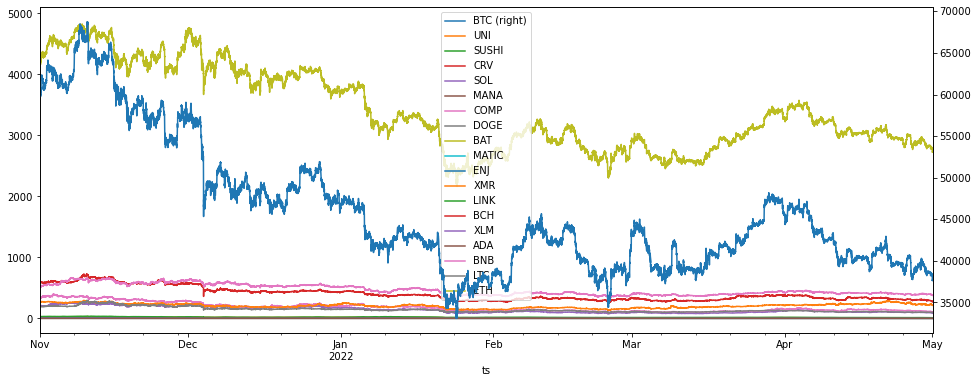

In [768]:
data.plot(secondary_y='BTC',figsize=(16,6))


## Eager Granger Approach

### Adf test for Stationary series.

In [769]:
from statsmodels.tsa.stattools import adfuller

#ADF test
fault=[]             #Store sample no. containing even 1 stationary price coin.
def ADFtest(list1):
    count=0
    for i in range(0,sample):
        flag=0
        for stock in list1[i].columns:
            result=adfuller(list1[i][stock])
            if(result[1]<=0.05):
                flag=1                                         #To store the sample no. for stationarity.
                print("For Null hypo {0} data is stationary".format(stock))
                print('p-value: {0} for {1} in sample {2}'.format(result[1],stock,i))
                #list1[i].drop(stock,axis=0,inplace=True)
                count+=1
        if(flag==1):
            fault.append(i)
                
    if(count==0):
        print("All price of coins are non stationary")
    else:
        print("{0} no. of coins of data are stationary".format(count))

In [770]:
fault

[]

In [771]:
ADFtest(data_sample)

For Null hypo SUSHI data is stationary
p-value: 0.04033889206864708 for SUSHI in sample 0
For Null hypo BAT data is stationary
p-value: 0.020787226993833983 for BAT in sample 1
For Null hypo ENJ data is stationary
p-value: 0.043798417706055554 for ENJ in sample 1
For Null hypo BTC data is stationary
p-value: 0.022630118579436437 for BTC in sample 6
For Null hypo MANA data is stationary
p-value: 0.016806105889465052 for MANA in sample 6
For Null hypo DOGE data is stationary
p-value: 0.028730123913037527 for DOGE in sample 6
For Null hypo ENJ data is stationary
p-value: 0.004338317004185501 for ENJ in sample 6
For Null hypo XMR data is stationary
p-value: 0.004908596128448961 for XMR in sample 6
For Null hypo BCH data is stationary
p-value: 0.005218287112950294 for BCH in sample 6
For Null hypo XLM data is stationary
p-value: 0.004384000189463949 for XLM in sample 6
For Null hypo ADA data is stationary
p-value: 0.007362173350834776 for ADA in sample 6
For Null hypo BNB data is stationary

In [772]:
from statsmodels.tsa.stattools import adfuller

#ADF test
fault_diff=[]
def ADFtest_diff(list1):
    count=0
    for i in range(0,sample):
        if(i not in fault):
            
            flag=0
            for stock in list1[i].columns:
                result=adfuller(list1[i][stock])
            
                if(result[1]>0.05):
                    #print("Against Null hypo data is stationary")
                    print("For Null hypo data is not stationary")
                    print('p-value: {0} for {1} in sample {2}'.format(result[1],stock,i))
                    #list1[i].drop(stock,axis=1,inplace=True)
                    count+=1
                    flag=1
            if(flag==1):
                fault_diff.append(i)
                
    if(count==0):
            print("All difference in price are stationary")
    else:
            print("{0} coin data are non-stationary",count)

In [773]:
ADFtest_diff(data_diff_sample)

All difference in price are stationary


In [774]:
fault_diff

[]

In [775]:
#Storing the qualifying samples.
fault_ff= fault+fault_diff
fault_ff.sort()
fault_ff

[0, 1, 6, 12, 18, 21, 23]

## Cointegration Test

In [776]:
#I(1)target and I(1) variable
'''
alt_coin=['ETH', 'BAT','UNI', 'LINK','COMP', 'MANA', 'MATIC','CRO', 'LTC', 'ENJ', 'CRV', 'SUSHI']
residuals=pd.DataFrame()
for i in alt_coin:
    Y = data[i]
    X = data['BTC']
    X= sm.add_constant(X)
    model = sm.OLS(Y,X)
    results = model.fit()
    residuals[i]= pd.DataFrame(results.resid)
'''


"\nalt_coin=['ETH', 'BAT','UNI', 'LINK','COMP', 'MANA', 'MATIC','CRO', 'LTC', 'ENJ', 'CRV', 'SUSHI']\nresiduals=pd.DataFrame()\nfor i in alt_coin:\n    Y = data[i]\n    X = data['BTC']\n    X= sm.add_constant(X)\n    model = sm.OLS(Y,X)\n    results = model.fit()\n    residuals[i]= pd.DataFrame(results.resid)\n"

In [777]:
#data_sample=[],dt_sample=[],data_diff_sample=[]
pair=pd.DataFrame()
pair_store=[]
pair_name_store=[]
for k in range(0,sample):
    if(k not in fault_ff):
        
    
        for i in coin:
            for j in coin:
                if i!=j:
                    Y = data_sample[k][i]
                    X = data_sample[k][j]
                    X= sm.add_constant(X)
                    model = sm.OLS(Y,X)
                    results = model.fit()
                    #res=
                    resid_dumm= pd.DataFrame(results.resid)
                    p_value=adfuller(resid_dumm)
                    if p_value[1]<0.05:
                        pair[(i,j)]= pd.DataFrame(results.resid)
                        pair_store.append((pair[(i,j)],k))
                        pair_name_store.append(((i,j),k))         
                        pair=pd.DataFrame()
                        
                        
                


In [778]:
#Storing coin pair name in frame.
pair_name_sel= pd.DataFrame(pair_name_store,columns={'pair_sel','sample no.'})
pair_name_sel

,pair_sel,sample no.
0,"(BTC, COMP)",2
1,"(UNI, XLM)",2
2,"(CRV, MANA)",2
3,"(COMP, BTC)",2
4,"(COMP, SUSHI)",2
...,...,...
1777,"(LTC, XLM)",24
1778,"(LTC, ADA)",24
1779,"(LTC, BNB)",24
1780,"(ETH, ADA)",24


### ECM 

In [779]:
data_diff_1=data_diff.shift(1)
data_diff_1.fillna(method='bfill',inplace=True)

In [780]:
fgd=[]
dasa=pd.DataFrame(pair_store[0][0])
dasa['samp no.']=pair_store[0][1]
fgd.append(dasa)
dasa=pd.DataFrame(pair_store[1][0])
dasa['samp no.']=pair_store[1][1]
fgd.append(dasa)
fgd[1]

,UNI,samp no.
,XLM,
ts,,
2021-11-15 00:00:00,0.717550,2
2021-11-15 00:05:00,0.694530,2
2021-11-15 00:10:00,0.670570,2
2021-11-15 00:15:00,0.751713,2
2021-11-15 00:20:00,0.693061,2
...,...,...
2021-11-22 23:35:00,0.023667,2
2021-11-22 23:40:00,0.014606,2


In [781]:
pd.DataFrame(pair_store[99][0])

,SUSHI
,CRV
ts,
2021-11-29 00:00:00,0.276895
2021-11-29 00:05:00,0.284224
2021-11-29 00:10:00,0.145515
2021-11-29 00:15:00,0.091123
2021-11-29 00:20:00,0.076060
...,...
2021-12-06 23:35:00,0.753580
2021-12-06 23:40:00,0.652365


In [782]:
sel_pair=[]
error_coeff=[]
sample_no=[]
num=0
for ch_sample in range(0,sample):
    if(ch_sample not in fault_ff):
        j=0
        pair_selected= pair_name_sel[pair_name_sel['sample no.']==ch_sample]['pair_sel']
        for i in pair_selected:
            print("{0} of sample no. {1}".format(i,ch_sample))
            if(j <len(pair_selected)):
                #pair_residual=pd.DataFrame(pair_store[j][0])
                y= pd.DataFrame(data_diff_sample[ch_sample][i[0]]) ###(Dependent,independent)
                X=pd.DataFrame()
                X[i[1]]=pd.DataFrame(data_diff_sample[ch_sample][i[1]])
                #X[str(i[1])+"1"]=data_diff_1[i[1]]    #Extended eqn of Graner Approach.
                X['residual']= (pair_store[num][0])
                X=sm.add_constant(X)
                model=sm.OLS(y,X)
                results=model.fit()
                print(results.params.loc['residual'])
                error_coeff.append(results.params.loc['residual'])
                sel_pair.append(i)
                sample_no.append(ch_sample)
                j+=1
                num+=1
    

('BTC', 'COMP') of sample no. 2
0.00457619487851235
('UNI', 'XLM') of sample no. 2
0.0041353868660773795
('CRV', 'MANA') of sample no. 2
0.00559036798490022
('COMP', 'BTC') of sample no. 2
0.009595061979340628
('COMP', 'SUSHI') of sample no. 2
0.007591439881459451
('DOGE', 'LINK') of sample no. 2
0.012212211317485736
('BAT', 'UNI') of sample no. 2
0.0077195509162049925
('BAT', 'MATIC') of sample no. 2
0.010871045261972995
('BAT', 'XMR') of sample no. 2
0.010396333776096096
('BAT', 'LINK') of sample no. 2
0.006515529005566444
('BAT', 'BCH') of sample no. 2
0.00540340546155255
('BAT', 'XLM') of sample no. 2
0.01084702190826543
('BAT', 'ADA') of sample no. 2
0.009471784760290206
('BAT', 'BNB') of sample no. 2
0.008984334519382619
('BAT', 'LTC') of sample no. 2
0.006324986909341766
('BAT', 'ETH') of sample no. 2
0.01064317635202686
('MATIC', 'BAT') of sample no. 2
0.005959719514656031
('MATIC', 'XMR') of sample no. 2
0.007610097727172109
('MATIC', 'XLM') of sample no. 2
0.00730422999961545

0.003954385345080113
('SUSHI', 'BAT') of sample no. 5
0.004397594268014241
('SUSHI', 'MATIC') of sample no. 5
0.004500949795010345
('SUSHI', 'ENJ') of sample no. 5
0.0044073357262306
('SUSHI', 'XMR') of sample no. 5
0.0034958439086126085
('SUSHI', 'LINK') of sample no. 5
0.003913062047081337
('SUSHI', 'BCH') of sample no. 5
0.003835557214596644
('SUSHI', 'XLM') of sample no. 5
0.00473764606502738
('SUSHI', 'ADA') of sample no. 5
0.004068992505959973
('SUSHI', 'LTC') of sample no. 5
0.00425950984182515
('SUSHI', 'ETH') of sample no. 5
0.004428632014266982
('CRV', 'UNI') of sample no. 5
0.008072268825220788
('CRV', 'XMR') of sample no. 5
0.007065461888039412
('CRV', 'LINK') of sample no. 5
0.01157072027985926
('CRV', 'XLM') of sample no. 5
0.00899444370691597
('CRV', 'LTC') of sample no. 5
0.010283771412740788
('SOL', 'DOGE') of sample no. 5
0.0014667502094034184
('SOL', 'BAT') of sample no. 5
0.003778056438437562
('MANA', 'BTC') of sample no. 5
0.006911873264594628
('MANA', 'SOL') of sa

0.003190736402694895
('XLM', 'ADA') of sample no. 7
0.01108317610740377
('XLM', 'BNB') of sample no. 7
0.00332997963260904
('ADA', 'UNI') of sample no. 7
0.006537215740637508
('ADA', 'BAT') of sample no. 7
0.007723280484532201
('ADA', 'LINK') of sample no. 7
0.01098122116650245
('ADA', 'BCH') of sample no. 7
0.0069807517411261556
('ADA', 'XLM') of sample no. 7
0.005792007659962887
('BNB', 'SUSHI') of sample no. 7
0.01103547479742774
('BNB', 'BCH') of sample no. 7
0.012645524542483045
('BNB', 'XLM') of sample no. 7
0.007383638831796882
('ETH', 'BTC') of sample no. 7
0.005903027318717113
('BTC', 'SOL') of sample no. 8
0.01579528711621476
('BTC', 'MANA') of sample no. 8
0.018097412802761018
('BTC', 'DOGE') of sample no. 8
0.012493518936769674
('BTC', 'MATIC') of sample no. 8
0.003781011050429107
('BTC', 'ADA') of sample no. 8
0.004865264591566218
('UNI', 'ENJ') of sample no. 8
0.004805325440416055
('SUSHI', 'UNI') of sample no. 8
0.002679149364287596
('SUSHI', 'CRV') of sample no. 8
0.001

0.008191652668598056
('BCH', 'BAT') of sample no. 9
0.004810617801704637
('BCH', 'ENJ') of sample no. 9
0.007035207922735851
('BCH', 'XMR') of sample no. 9
0.010826503882531648
('BCH', 'ADA') of sample no. 9
0.005096066602271274
('BCH', 'BNB') of sample no. 9
0.014032539124804252
('XLM', 'BTC') of sample no. 9
0.01031531643377906
('XLM', 'UNI') of sample no. 9
0.0076396245331608915
('XLM', 'SUSHI') of sample no. 9
0.012838972826416412
('XLM', 'CRV') of sample no. 9
0.005487532339897007
('XLM', 'SOL') of sample no. 9
0.011961659199117286
('XLM', 'COMP') of sample no. 9
0.0019516035526918707
('XLM', 'BAT') of sample no. 9
0.007624518739765809
('XLM', 'ENJ') of sample no. 9
0.008659440224230036
('XLM', 'XMR') of sample no. 9
0.00907414529417842
('XLM', 'BCH') of sample no. 9
0.009160557986665815
('XLM', 'BNB') of sample no. 9
0.006000729721663271
('XLM', 'LTC') of sample no. 9
0.011974382659615802
('XLM', 'ETH') of sample no. 9
0.004395283374444844
('ADA', 'CRV') of sample no. 9
0.0068163

0.0077216349506567025
('XMR', 'LINK') of sample no. 11
0.006369461521697928
('LINK', 'CRV') of sample no. 11
0.017390592909417996
('LINK', 'MATIC') of sample no. 11
0.008499086763948595
('LINK', 'XMR') of sample no. 11
0.006448488624330897
('LINK', 'ADA') of sample no. 11
-4.924088641089397e-05
('LINK', 'LTC') of sample no. 11
0.0024405058722281932
('BCH', 'SUSHI') of sample no. 11
0.00379175947633148
('BCH', 'CRV') of sample no. 11
0.0034045006922758963
('BCH', 'MANA') of sample no. 11
0.004682554369030206
('BCH', 'COMP') of sample no. 11
0.0057811064408409135
('BCH', 'DOGE') of sample no. 11
0.002366215399267307
('BCH', 'BAT') of sample no. 11
0.006828423875124733
('BCH', 'ENJ') of sample no. 11
0.005457391975154432
('BCH', 'BNB') of sample no. 11
0.00311562634692173
('BCH', 'ETH') of sample no. 11
0.006737407568789671
('XLM', 'MANA') of sample no. 11
0.009324594114712708
('XLM', 'COMP') of sample no. 11
0.007602135689024021
('XLM', 'DOGE') of sample no. 11
0.007987710244109797
('XLM

0.009517704796080873
('MANA', 'SUSHI') of sample no. 14
0.007258835951961005
('MANA', 'CRV') of sample no. 14
0.008965050501964692
('MANA', 'COMP') of sample no. 14
0.01019925635350143
('MANA', 'MATIC') of sample no. 14
0.00334264748144957
('MANA', 'ENJ') of sample no. 14
0.010967034931930084
('MANA', 'LINK') of sample no. 14
0.010486719570361867
('MANA', 'XLM') of sample no. 14
0.005637063115840113
('MANA', 'ADA') of sample no. 14
0.010400296543297658
('MANA', 'LTC') of sample no. 14
0.0031079858356591085
('MANA', 'ETH') of sample no. 14
0.00595278957978688
('COMP', 'UNI') of sample no. 14
0.013823246863278776
('COMP', 'SUSHI') of sample no. 14
0.010583980620359406
('COMP', 'CRV') of sample no. 14
0.014874001308376822
('COMP', 'SOL') of sample no. 14
0.00867508853382117
('COMP', 'MANA') of sample no. 14
0.007027826057178504
('COMP', 'DOGE') of sample no. 14
0.0038359597284344828
('COMP', 'BAT') of sample no. 14
0.009546761586185455
('COMP', 'MATIC') of sample no. 14
0.0032527679664131

0.014110908984213744
('UNI', 'CRV') of sample no. 15
0.007351044159146978
('UNI', 'DOGE') of sample no. 15
0.0012727986571069762
('UNI', 'BCH') of sample no. 15
0.0016145917838436231
('UNI', 'ADA') of sample no. 15
0.016385266899523007
('SUSHI', 'UNI') of sample no. 15
0.021056177970911947
('SUSHI', 'DOGE') of sample no. 15
0.003229970838958629
('SUSHI', 'LINK') of sample no. 15
0.010181714475356811
('SUSHI', 'BCH') of sample no. 15
0.004810097438300313
('SUSHI', 'XLM') of sample no. 15
0.00775616526145891
('SUSHI', 'ADA') of sample no. 15
0.03241735261420428
('CRV', 'UNI') of sample no. 15
0.0038986871749161606
('CRV', 'COMP') of sample no. 15
0.0050751271861133465
('CRV', 'DOGE') of sample no. 15
-0.00031472342464871164
('CRV', 'MATIC') of sample no. 15
0.009686399919545091
('CRV', 'ENJ') of sample no. 15
0.007615549814390598
('CRV', 'LINK') of sample no. 15
0.0033635175147956956
('CRV', 'BCH') of sample no. 15
-0.00035938587487332617
('CRV', 'BNB') of sample no. 15
0.007135981916946

0.014184194168426872
('BNB', 'COMP') of sample no. 16
0.020746631437307258
('BNB', 'MATIC') of sample no. 16
0.009634399433119249
('BNB', 'ADA') of sample no. 16
0.013856550685016658
('BNB', 'LTC') of sample no. 16
0.015390388364444306
('LTC', 'MANA') of sample no. 16
0.007837232460128957
('LTC', 'COMP') of sample no. 16
0.011894057761830534
('LTC', 'BAT') of sample no. 16
0.010168634785616484
('LTC', 'MATIC') of sample no. 16
0.009308078299004433
('LTC', 'ENJ') of sample no. 16
0.009619846166421708
('LTC', 'XLM') of sample no. 16
0.02179287697624979
('LTC', 'ADA') of sample no. 16
0.011024034071438904
('LTC', 'BNB') of sample no. 16
0.01270065827856296
('ETH', 'BAT') of sample no. 16
0.004921431448414846
('BTC', 'UNI') of sample no. 17
-0.0013134362084163066
('BTC', 'COMP') of sample no. 17
0.002880006563950649
('BTC', 'MATIC') of sample no. 17
0.003191190599668601
('UNI', 'BTC') of sample no. 17
-0.00020769555562463542
('UNI', 'SUSHI') of sample no. 17
0.005939644087726963
('UNI', 'S

0.0212754283918692
('UNI', 'CRV') of sample no. 19
0.017087356686877005
('UNI', 'SOL') of sample no. 19
0.015522800865769923
('UNI', 'COMP') of sample no. 19
0.03256374121867634
('UNI', 'MATIC') of sample no. 19
0.017440471306939796
('UNI', 'LINK') of sample no. 19
0.012576862850420256
('UNI', 'BNB') of sample no. 19
0.023164621273437883
('UNI', 'ETH') of sample no. 19
0.024944906811387602
('SUSHI', 'BTC') of sample no. 19
0.008631509728741028
('SUSHI', 'UNI') of sample no. 19
0.014413106730278426
('SUSHI', 'CRV') of sample no. 19
0.009611685649344795
('SUSHI', 'SOL') of sample no. 19
0.010619350901117961
('SUSHI', 'MATIC') of sample no. 19
0.00906375300636218
('SUSHI', 'ENJ') of sample no. 19
0.009739748367617903
('SUSHI', 'LINK') of sample no. 19
0.00852756902317403
('SUSHI', 'BNB') of sample no. 19
0.017440716818974973
('SUSHI', 'LTC') of sample no. 19
0.005361294008126178
('SUSHI', 'ETH') of sample no. 19
0.019252544805183104
('CRV', 'BTC') of sample no. 19
0.003636368843125782
('C

0.010989149260614997
('MANA', 'SOL') of sample no. 20
0.017411257701808937
('MANA', 'DOGE') of sample no. 20
0.015736365784651443
('MANA', 'BAT') of sample no. 20
0.0034817328513552237
('MANA', 'MATIC') of sample no. 20
0.019836918091802495
('MANA', 'ADA') of sample no. 20
0.009825300871991339
('COMP', 'SUSHI') of sample no. 20
0.006251569177818172
('COMP', 'DOGE') of sample no. 20
0.00894065917961224
('COMP', 'BAT') of sample no. 20
0.016881357486434125
('COMP', 'XMR') of sample no. 20
0.01503313347943561
('COMP', 'LINK') of sample no. 20
0.006173678049011278
('COMP', 'XLM') of sample no. 20
0.012036498359927896
('COMP', 'BNB') of sample no. 20
0.010616400259969275
('COMP', 'ETH') of sample no. 20
0.011962519113193008
('DOGE', 'SUSHI') of sample no. 20
0.003681166975687553
('DOGE', 'CRV') of sample no. 20
0.006193201208032884
('DOGE', 'MANA') of sample no. 20
0.011544163289115993
('DOGE', 'BAT') of sample no. 20
0.004318309863567919
('DOGE', 'MATIC') of sample no. 20
0.012376623751126

0.002512163571833952
('BAT', 'SOL') of sample no. 22
0.006069480049217467
('BAT', 'MANA') of sample no. 22
0.009726078025811838
('BAT', 'COMP') of sample no. 22
0.012667287485146521
('BAT', 'MATIC') of sample no. 22
0.00729369777281013
('BAT', 'LINK') of sample no. 22
0.009454204091955302
('BAT', 'BCH') of sample no. 22
0.002864080334709162
('BAT', 'XLM') of sample no. 22
0.008121310309778253
('BAT', 'ADA') of sample no. 22
0.0004265639781669367
('BAT', 'BNB') of sample no. 22
-0.0004457801632619398
('BAT', 'LTC') of sample no. 22
0.007963483685521973
('BAT', 'ETH') of sample no. 22
0.0015908810778755542
('MATIC', 'UNI') of sample no. 22
0.015047136229603644
('MATIC', 'SOL') of sample no. 22
0.022139879675256807
('MATIC', 'MANA') of sample no. 22
0.021555065024772863
('MATIC', 'COMP') of sample no. 22
0.013305749422279098
('MATIC', 'BAT') of sample no. 22
0.008556873205665484
('MATIC', 'LINK') of sample no. 22
0.013244257253476645
('MATIC', 'BCH') of sample no. 22
0.013887163805412816


0.01784845877176871
('ADA', 'ETH') of sample no. 24
0.014639283237770223
('BNB', 'UNI') of sample no. 24
0.006577744750821792
('BNB', 'MANA') of sample no. 24
0.012809141095687867
('BNB', 'COMP') of sample no. 24
0.006546385113869623
('BNB', 'LINK') of sample no. 24
0.015100525555786502
('BNB', 'BCH') of sample no. 24
0.010209632544095678
('BNB', 'XLM') of sample no. 24
0.015208001834123498
('BNB', 'ADA') of sample no. 24
0.0299741956751212
('BNB', 'LTC') of sample no. 24
0.01328870860397993
('BNB', 'ETH') of sample no. 24
0.010980990161617214
('LTC', 'UNI') of sample no. 24
0.008046227818478004
('LTC', 'MANA') of sample no. 24
0.010609214090178929
('LTC', 'COMP') of sample no. 24
0.009546118257851566
('LTC', 'LINK') of sample no. 24
0.008091111037511213
('LTC', 'BCH') of sample no. 24
0.011340456327749557
('LTC', 'XLM') of sample no. 24
0.015413468478530666
('LTC', 'ADA') of sample no. 24
0.01712067476584054
('LTC', 'BNB') of sample no. 24
0.009621963363569668
('ETH', 'ADA') of sample

In [783]:
best_pair=[]
dfdf=data_final.copy()
for ch_sample in range(0,sample):
    if(ch_sample not in fault_ff):
        temp= data_final[data_final['sample']==ch_sample]
        temp_2=pd.DataFrame(temp.sort_values(by='error_coeff')).reset_index()
        temp_2.drop('index',axis=1,inplace=True)
        print("Sample No.: {0}, best selectd pair: {1}".format(ch_sample, temp_2['sel_pair'][0]))
        print('Error Coefficient: {0}'.format(temp_2['error_coeff'][0]))
        best_pair.append((temp_2['sel_pair'][0],ch_sample))

Sample No.: 2, best selectd pair: ('BNB', 'BAT')
Error Coefficient: -0.0002272541078729895
Sample No.: 3, best selectd pair: ('LINK', 'BAT')
Error Coefficient: -0.00043952031242989147
Sample No.: 4, best selectd pair: ('BTC', 'BNB')
Error Coefficient: -0.0005027058244519541
Sample No.: 5, best selectd pair: ('SOL', 'DOGE')
Error Coefficient: 0.0014667502094034184
Sample No.: 7, best selectd pair: ('BTC', 'ETH')
Error Coefficient: 2.9505047266871498e-05
Sample No.: 8, best selectd pair: ('ETH', 'BCH')
Error Coefficient: 0.0006781315884852842
Sample No.: 9, best selectd pair: ('BNB', 'ENJ')
Error Coefficient: -0.0012818492476283786
Sample No.: 10, best selectd pair: ('LTC', 'LINK')
Error Coefficient: 0.0015092907305217875
Sample No.: 11, best selectd pair: ('CRV', 'ADA')
Error Coefficient: -0.0007274748931987984
Sample No.: 13, best selectd pair: ('SOL', 'LINK')
Error Coefficient: -0.0006432913135144147
Sample No.: 14, best selectd pair: ('MATIC', 'SUSHI')
Error Coefficient: -0.000469321

In [836]:
useful_dates=[]
for ch_sample in range(0,sample):
    if(ch_sample not in fault_ff):
        useful_dates.append(dt_sample[ch_sample])
        

In [839]:
str(useful_dates)

"[('2021-11-15', '2021-11-22'), ('2021-11-22', '2021-11-29'), ('2021-11-29', '2021-12-06'), ('2021-12-06', '2021-12-13'), ('2021-12-20', '2021-12-27'), ('2021-12-27', '2022-01-03'), ('2022-01-03', '2022-01-10'), ('2022-01-10', '2022-01-17'), ('2022-01-17', '2022-01-24'), ('2022-01-31', '2022-02-07'), ('2022-02-07', '2022-02-14'), ('2022-02-14', '2022-02-21'), ('2022-02-21', '2022-02-28'), ('2022-02-28', '2022-03-07'), ('2022-03-14', '2022-03-21'), ('2022-03-21', '2022-03-28'), ('2022-04-04', '2022-04-11'), ('2022-04-18', '2022-04-25')]"

In [842]:
Best_pair=pd.DataFrame(best_pair,columns={'Selected Pair','sample No.'},index=useful_dates)

In [844]:
Best_pair

,Selected Pair,sample No.
"(2021-11-15, 2021-11-22)","(BNB, BAT)",2
"(2021-11-22, 2021-11-29)","(LINK, BAT)",3
"(2021-11-29, 2021-12-06)","(BTC, BNB)",4
"(2021-12-06, 2021-12-13)","(SOL, DOGE)",5
"(2021-12-20, 2021-12-27)","(BTC, ETH)",7
"(2021-12-27, 2022-01-03)","(ETH, BCH)",8
"(2022-01-03, 2022-01-10)","(BNB, ENJ)",9
"(2022-01-10, 2022-01-17)","(LTC, LINK)",10
"(2022-01-17, 2022-01-24)","(CRV, ADA)",11
"(2022-01-31, 2022-02-07)","(SOL, LINK)",13
